# Differentiable Physics VII: Incompressible Navier Stokes

## Navier Stokes Equations

We limit the scope of the solver with the following constraints:

- We use the conservative form of the equations, meaning we are looking at a volume which is fixed in space and the fluid is moving through it.
- We use a 2D grid based approach, where each cell in the grid represents a volume element and has size $\Delta x \times \Delta y$.
- The fluid is incompressible. This means that the density $\rho$ is constant across the grid.

The following quantities are defined on the grid:

- $V$ : velocity vector field. $V = \begin{pmatrix} u \\ v \end{pmatrix}$
- $p_{i,j}$ : pressure scalar field
- $\rho$ : density, constant across the grid
- $\nu$: kinematic viscosity, constant across the grid
- $\tau_{i,j}$ : dye concentration vector field ( for visualization purposes )

The equations for the incompressible Navier Stokes equations are:

1. Momentum conservation:
$$\frac{\partial V}{\partial t} + V \cdot \nabla U= -\frac{1}{\rho} \nabla p + \nu \Delta U$$

2. Incompressibility or mass conservation:
$$\nabla \cdot V = 0$$

The momentum conservation equation in 2D is composed of two equations, one for each component of the velocity vector field:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \tag{1}$$

$$\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \tag{2}$$

## Vorticity-Steam Function Approach

We define the vorticity vector field $\zeta$ for 2D flows

$$\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \tag{3}$$

And the stream function $\psi$ such that:

$$u = \frac{\partial \psi}{\partial y} \tag{4} $$ 
$$v = -\frac{\partial \psi}{\partial x}\tag{5}$$

We can subtract (1) from (2) where the pressure terms cancel out and we the vorticity transport equation:

$$\frac{\partial \zeta}{\partial t} + u \frac{\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} = \nu \left( \frac{\partial^2 \zeta}{\partial x^2} + \frac{\partial^2 \zeta}{\partial y^2} \right)$$

Furthermore, we can substitute (4) and (5) into (3) and we get the Poisson equation for the stream function:

$$\frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} = -\zeta$$

We can use the Mac Cormack method t solve the vorticity transport equation and the jacobi method to solve the Poisson equation for the stream function.

## Mac Cormack Method for Vorticity Transport Equation

We define vectors $E$ and $F$:

$$ E = u \zeta - \nu \frac{\partial \zeta}{\partial x} \quad \quad F = v \zeta - \nu \frac{\partial \zeta}{\partial y}$$

Recall the Mac Cormack method:

$$\bar{V}_{i,j}^{n+1} = U_{i,j}^n - \frac{\Delta t}{\Delta x} \left( E_{i+1, j}^{n} - E_{i, j}^{n} \right) - \frac{\Delta t}{\Delta y} \left( F_{i, j+1}^{n} - F_{i, j}^{n} \right)$$

$$U_{i,j}^{n+1} = \frac{1}{2} \left[ \left( V_{i,j}^n + \bar{V}_{i,j}^{n+1} \right) - \frac{\Delta t}{ \Delta x} \left( \bar{E}_{i, j}^{n+1} - \bar{E}_{i-1, j}^{n+1} \right) - \frac{\Delta t}{\Delta y} \left( \bar{F}_{i, j}^{n+1} - \bar{F}_{i, j-1}^{n+1} \right) \right]$$

In [10]:
import jax.numpy as jnp
from jax import value_and_grad, jit
from functools import partial
from jax.lax import fori_loop

@partial(jit, static_argnames=("delta", "axis"))
def fd(f : jnp.ndarray, delta : float, axis : int):
    """Forward difference"""
    return jnp.roll(f, -1, axis=axis) - f / delta

@partial(jit, static_argnames=("delta", "axis"))
def bd(f : jnp.ndarray, delta : float, axis : int):
    """Backward difference"""
    return f - jnp.roll(f, 1, axis=axis) / delta

@partial(jit, static_argnames=("delta", "axis"))
def cd(f : jnp.ndarray, delta : float, axis : int):
    """Central difference"""
    return (jnp.roll(f, -1, axis=axis) - jnp.roll(f, 1, axis=0)) / (2*delta)

@partial(jit, static_argnames=("delta", "axis"))
def cd2(f : jnp.ndarray, delta : float, axis : int):
    """Second order central difference"""
    return (jnp.roll(f, -1, axis=axis) - 2*f + jnp.roll(f, 1, axis=axis)) / delta**2


In [29]:
@partial(jit, static_argnames=("dx", "dy", "nu"))	
def get_EF(
    zeta : jnp.ndarray, # vorticity
    psi : jnp.ndarray, # streamfunction
    dx : float, # grid spacing
    dy : float,
    nu : float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Returns the E and F terms of the vorticity transport equation
    """
    u = cd(psi, dy, axis=1)
    v = -cd(psi, dx, axis=0)

    E = u * zeta - nu * cd2(zeta, dx, axis=0)
    F = v * zeta - nu * cd2(zeta, dy, axis=1)

    return E, F

In [33]:
@partial(jit, static_argnames=("dx", "dy", "dt", "nu"))
def mac_cormack_step(
    S : jnp.ndarray, # state vector
    dx : float, # grid spacing
    dy : float,
    dt : float,
    nu : float,
) -> jnp.ndarray:
    """
    Performs a single timestep of the mac_cormack scheme
    """
    zeta = S[:, :, 0]
    psi = S[:, :, 1]

    E, F = get_EF(zeta, psi, dx, dy, nu)
    zeta_hat = zeta - dt * cd(E, dx, 0) - dt * cd(F, dy, 0) 

    E_hat, F_hat = get_EF(zeta_hat, psi, dx, dy, nu)
    zeta_fwd = 0.5 * (zeta + zeta_hat - dt * (cd(E_hat, dx, 0) + cd(F_hat, dy, 1)))

    return jnp.stack([zeta_fwd, psi], axis=2)

In [47]:
nx = 64 
ny = 64

dx = 1.0
dy = 1.0
dt = 0.1

nu = 1.0

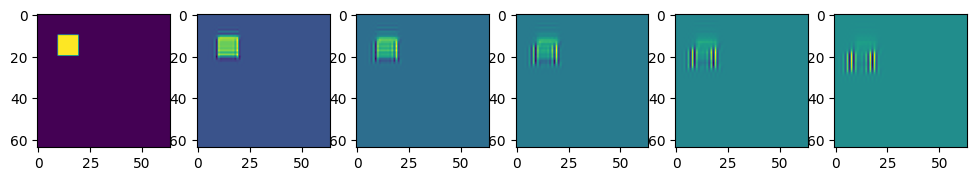

In [50]:
import matplotlib.pyplot as plt

S = jnp.zeros((nx, ny, 2), dtype=jnp.float32)
S = S.at[10:20, 10:20, 0].set(1.0)

n_view = 6
fig, axs = plt.subplots(1, n_view, figsize=(n_view*2, 4))

for i in range(n_view):
    axs[i].imshow(S[:, :, 0])

    for _ in range(5):
        S = mac_cormack_step(S, dx, dy, dt, nu)



In [51]:
from jax.lax import fori_loop

@partial(jit, static_argnames=("dx", "dy"))
def jacobi_step(
        x : jnp.ndarray, # pressure field
        f : jnp.ndarray, # RHS
        dx : float, 
        dy : float
    ) -> jnp.ndarray:
    
    p_new = jnp.roll(x, 1, axis=0) + jnp.roll(x, -1, axis=0) + \
        jnp.roll(x, 1, axis=1) + jnp.roll(x, -1, axis=1) - \
        dx**2 * f

    return p_new / 4

@partial(jit, static_argnames=("dx", "dy", "iterations"))
def jacobi(
        x_0 : jnp.ndarray, 
        f : jnp.ndarray, 
        dx : float, 
        dy : float, 
        iterations : int
    ) -> jnp.ndarray:

    assert dx == dy

    body_fun = lambda i, p_i: jacobi_step(p_i, f, dx, dy)

    p_n = fori_loop(0, iterations, body_fun, x_0)
    
    return p_n

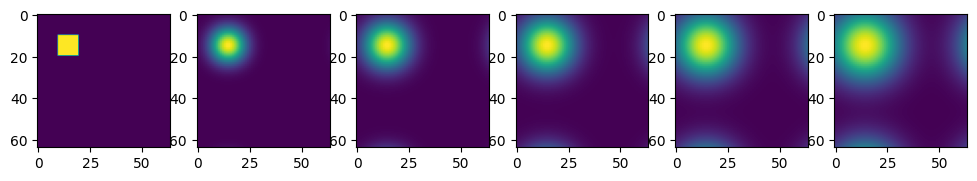

In [53]:
import matplotlib.pyplot as plt

x = jnp.zeros((nx, ny), dtype=jnp.float32)
x = x.at[10:20, 10:20].set(1.0)
f = jnp.zeros((nx, ny), dtype=jnp.float32)

n_view = 6
fig, axs = plt.subplots(1, n_view, figsize=(n_view*2, 4))

for i in range(n_view):
    axs[i].imshow(x)

    for _ in range(5):
        x = jacobi(x, f, dx, dy, 10)



In [ ]:
def simulation(
    S : jnp.ndarray, 
    dx : float, 
    dy : float, 
    dt : float, 
    nu : float, 
    iterations : int
) -> jnp.ndarray:

    S = mac_cormack_step(S, dx, dy, dt, nu)
    zeta = S[:, :, 0]
    psi = S[:, :, 1]

    f = -zeta
    psi_fwd = jacobi(jnp.zeros_like(f), f, dx, dy, iterations)

    u = cd(p, dy, 0)
    v = -cd(p, dx, 1)

    S = S.at[:, :, 0].set(zeta - dt * cd(u * zeta, dx, 0) - dt * cd(v * zeta, dy, 1))

    return S